In [1]:
#!pip install tensorflow

# Artistic vs. Arabic MNIST 


## Introduction to challenge
We have decided to take a dataset from Kaggle ([Arabic Handwritten Characters Dataset](https://www.kaggle.com/mloey1/ahcd1)) for this challenge.   

- 16,800 characters written by 60 participants
- Each participant wrote each character (from ’alef’ to ’yeh’) ten times on two forms 
- The forms were scanned at the resolution of 300 dpi. Each block is segmented automatically using Matlab 2016a to determining the coordinates for each block. 
- The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class).
- Writers of training set and test set are exclusive. Ordering of including writers to test set are randomized to make sure that writers of test set are not from a single institution (to ensure variability of the test set).

__Acknowledgements__:

- A. El-Sawy, M. Loey, and H. EL-Bakry, “Arabic handwritten characters recognition using convolutional neural network,” WSEAS Transactions on Computer Research, vol. 5, pp. 11–19, 2017. 
https://doi.org/10.1007/978-3-319-48308-5_54
https://link.springer.com/chapter/10.1007/978-3-319-48308-5_54

- A. El-Sawy, H. EL-Bakry, and M. Loey, “CNN for handwritten arabic digits recognition based on lenet-5,” in Proceedings of the International Conference on Advanced Intelligent Systems and Informatics 2016, vol. 533, pp. 566–575, Springer International Publishing, 2016.
https://www.wseas.org/multimedia/journals/computerresearch/2017/a045818-075.php

- Loey, Mohamed, Ahmed El-Sawy, and Hazem El-Bakry. "Deep learning autoencoder approach for handwritten arabic digits recognition." arXiv preprint arXiv:1706.06720 (2017).
https://arxiv.org/abs/1706.06720

## Data Import
Uncomment and adapt path. 

In [2]:
def get_kaggle_dataset():
  from google.colab import files
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
  # Then move kaggle.json into the folder where the API expects to find it.
  !mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json
  !kaggle datasets download -d 'mloey1/ahcd1'
  !mv ./*.zip /content/drive/MyDrive/DeepLearningInVisionHSLU/
  !unzip -q /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip -d /content/drive/MyDrive/DeepLearningInVisionHSLU/
  !rm /content/drive/MyDrive/DeepLearningInVisionHSLU/*.zip

## Imports

In [3]:
# Built-in imports
import os, datetime, pathlib, random 
from glob import glob
import math
from math import ceil, floor

# Basic imports
import numpy as np
import pandas as pd   

# Ploting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False
%matplotlib inline


import seaborn as sns
sns.set(color_codes=True)

import PIL
from PIL import Image
import skimage
from skimage import color, io
#from skimage import data
from skimage import transform

# Tensorflow imports
import tensorflow as tf
print(f'Tensorflow version is: {tf.version.VERSION}')
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image as kp_image
from tensorflow.keras.callbacks import TensorBoard 
from tensorflow.keras import applications, optimizers, models, losses, layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
#from tensorflow.keras.metrics import 

# Train-test-split and evaluation imports
from sklearn.model_selection import train_test_split # If required
from sklearn import metrics # classification report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import KFold

Tensorflow version is: 2.7.0
Found GPU at: /device:GPU:0


## Definitions

In [4]:
# Divides the input array into chunks of letters
def row_calculator(number_of_images, number_of_columns):
    if number_of_images % number_of_columns != 0:
        return (number_of_images / number_of_columns)+1
    else:
        return (number_of_images / number_of_columns)

# Display images by size and number of plots
def display_image(x, img_size, number_of_images):
    # Standard plot size
    plt.figure(figsize = (16, 9))
    # Takes only images 
    if x.shape[0] > 0:
        n_samples = x.shape[0]
        x = x.reshape(n_samples, img_size, img_size)
        number_of_rows = row_calculator(number_of_images, 4)
        for i in range(number_of_images):
            plt.subplot(number_of_rows, 4, i+1)
            plt.imshow(x[i])

# Show image by number
def show_image_by_num(img_num,array):
  img_num = img_num
  plt.imshow(test_data[img_num][:,:,0])
  plt.axis('off')

def valid_imshow_data(data):
    data = np.asarray(data)
    if data.ndim == 2:
        return True
    elif data.ndim == 3:
        if 3 <= data.shape[2] <= 4:
            return True
        else:
            print('The "data" has 3 dimensions but the last dimension '
                  'must have a length of 3 (RGB) or 4 (RGBA), not "{}".'
                  ''.format(data.shape[2]))
            return False
    else:
        print('To visualize an image the data must be 2 dimensional or '
              '3 dimensional, not "{}".'
              ''.format(data.ndim))
        return False

# Show content of dictionary
def get_dir_content(path):
  return os.listdir(path)

# load image
def load_img(path):
  return io.imread(path)

# Show image
def show_image(image, title='Image',cmap_type='gray'):
  plt.imshow(image, cmap=cmap_type)
  plt.title(title)
  plt.axis('off')
  plt.show()

# Get size of images
def get_shape(img_array):
  return np.shape(img_array)

# Convert img to grayscale
def to_grayscale(img_array):
  grayscale = color.rgb2gray(img_array)
  grayscale *= 255
  return grayscale#.astype(np.uint8)

# Save new image
def save_new_img(img_array, filename, img_path, n):
  io.imsave(str(img_path).replace(filename, filename + f'__c_{n}'), img_array)

# Flip image left-right
def flip_lr(img_array):
  return np.fliplr(img_array)

# Flip image up-side-down
def flip_ud(img_array):
  return np.flipud(img_array)

# Warp image 
def warping(img_array):
  tform = transform.SimilarityTransform(
      scale=1, 
      rotation=0,
      translation=(
          np.random.normal(0,img_array.shape[0]/4),
          np.random.normal(0,img_array.shape[1]/4))
      )
  return transform.warp(img_array,tform)

# Rotate image
def rotate(img_array):
  return transform.rotate(img_array, np.random.normal(0,40))


## Pre-Processing


## Load data and labels

The train Images csv has 1024 columns and 13440 rows. Each column represents a pixel in an image and each row represents an individual grayscale images.

The value of each pixel varies from 0 -255.

Each column 

In [5]:
# Path to project
path_project_dir = pathlib.Path('/content/drive/MyDrive/DeepLearningInVisionHSLU/DLV03_Project/')
# Path to data 
path_to_data = path_project_dir.joinpath('data','train_test') / 'Arabic Handwritten Characters Dataset CSV' # because of github, this folder has been moved to the parent directory. 
# Path to images
path_to_images = path_project_dir.joinpath('data','images')

# Load train/test data
train_data = pd.read_csv(path_to_data.joinpath('csvTrainImages 13440x1024.csv'),header = None)
test_data = pd.read_csv(path_to_data.joinpath('csvTestImages 3360x1024.csv'),header = None)
# Load train/test labels
train_label = pd.read_csv(path_to_data.joinpath('csvTrainLabel 13440x1.csv'),header = None)#.rename(columns={0:'label'})
test_label = pd.read_csv(path_to_data.joinpath('csvTestLabel 3360x1.csv'),header = None)#.rename(columns={0:'label'})

## Check set
print('='*20)
print('Training data info')
print('='*20)
print(train_data.info(),'\n')
print('\n')
print('='*20)
print('Training labels info')
print('='*20)
print(train_label.info(),'\n')

print('='*20)
print('Test data info')
print('='*20)
print(test_data.info(),'\n')
print('\n')
print('='*20)
print('Test labels info')
print('='*20)
print(test_label.info(),'\n')
print('='*20)

Training data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 105.0 MB
None 



Training labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13440 entries, 0 to 13439
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       13440 non-null  int64
dtypes: int64(1)
memory usage: 105.1 KB
None 

Test data info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Columns: 1024 entries, 0 to 1023
dtypes: int64(1024)
memory usage: 26.3 MB
None 



Test labels info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3360 entries, 0 to 3359
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       3360 non-null   int64
dtypes: int64(1)
memory usage: 26.4 KB
None 



In [6]:
print(train_data.shape)
print(train_data.shape[0])

(13440, 1024)
13440


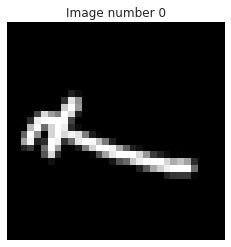

In [7]:
for i in range(0,train_data.shape[0],32):
  show_image(
    np.reshape(
        train_data.iloc[i,:].values.astype('float32'),
        (32,32),
    ), title=f'Image number {i}'
  )
  break

The database is partitioned into two sets: 
- Training set (13,440 characters to 480 images per class) => 28 classes
- Test set (3,360 characters to 120 images per class) => 28 class

In [8]:
print('Training:')
print(f'The shape of the df is: {train_data.shape}')
print(f'The meaning is: {train_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')
print('='*50)
print('Test:')
print(f'The shape of the df is: {test_data.shape}')
print(f'The meaning is: {test_data.shape[0]} letters divided in 28 categories with a (flatten) shape of {train_data.shape[1]} (32x32) pixels.')

Training:
The shape of the df is: (13440, 1024)
The meaning is: 13440 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.
Test:
The shape of the df is: (3360, 1024)
The meaning is: 3360 letters divided in 28 categories with a (flatten) shape of 1024 (32x32) pixels.


In [9]:
# Convert images to float32
train_data = train_data.iloc[:,:].values.astype('float32')
train_label = train_label.iloc[:,:].values.astype('int32')-1

test_data = test_data.iloc[:,:].values.astype('float32')
test_label = test_label.iloc[:,:].values.astype('int32')-1

### Show: Sample of training images

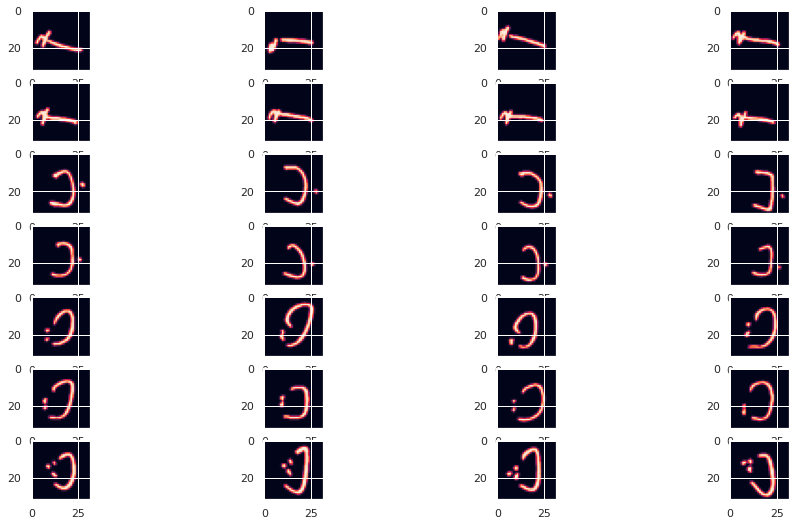

In [10]:
# Ten images 
display_image(train_data, 32, 28)

### Show: Sample of test images

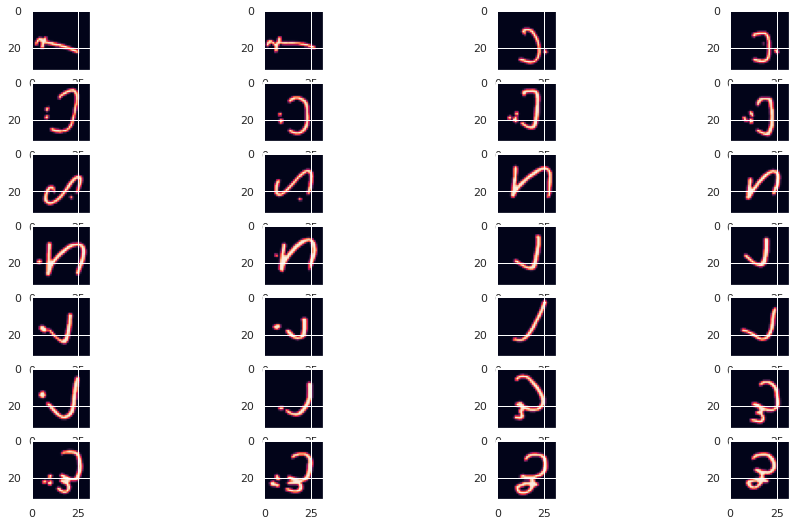

In [11]:
display_image(test_data, 32, 28)

### Shape check

In [12]:
print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 1024) (13440, 1)
(3360, 1024) (3360, 1)


### Normalization, zero-centering, categorical transformations

In [13]:
# Normalization [0,255] -> [0,1]
train_data = train_data/255
test_data = test_data/255

# Reshape to 2D -> #, height, width, rgb
train_data = train_data.reshape([-1, 32, 32, 1])
test_data = test_data.reshape([-1, 32, 32, 1])

# Categorical variable
train_label = tf.keras.utils.to_categorical(train_label,28)
test_label = tf.keras.utils.to_categorical(test_label,28)

print(train_data.shape, train_label.shape)
print(test_data.shape, test_label.shape)

(13440, 32, 32, 1) (13440, 28)
(3360, 32, 32, 1) (3360, 28)


### ImageDataGenerator: 
Generate batches of tensor image data with real-time data augmentation. This data is looped over in batches. Basically, It is used to load the images in batches.

In [14]:
validation_split = 0.2 

datagen = ImageDataGenerator(
    validation_split = validation_split,
    featurewise_center=False, 
    samplewise_center=False,  
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range = 0.1,  
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False)


## Model 1 
[CONV2D - CONV2D - MAXPOOL - DROPOUT] [CONV2D - CONV2D - MAXPOOL - DROPOUT] [DENSE - DENSE - DROPOUT]

### Architecture

In [15]:
with tf.device('/device:GPU:0'):
  num_classes = train_label.shape[1]
  image_size = train_data.shape[1]

  model_1 = tf.keras.Sequential()

  model_1.add(tf.keras.layers.Conv2D(32, (5, 5), padding='same', input_shape = (image_size, image_size, 1)))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Conv2D(32, (5, 5))) # padding='same'? 
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
  model_1.add(tf.keras.layers.Dropout(0.25))

  model_1.add(tf.keras.layers.Conv2D(64, (3, 3), padding='same'))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Conv2D(64, (3, 3)))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2))) # strides=(2,2)?
  model_1.add(tf.keras.layers.Dropout(0.25))

  model_1.add(tf.keras.layers.Flatten())
  model_1.add(tf.keras.layers.Dense(512))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Dense(num_classes))
  model_1.add(tf.keras.layers.Activation('relu'))
  model_1.add(tf.keras.layers.Dropout(0.5))
  model_1.add(tf.keras.layers.Activation('softmax'))

  model_1.compile(
      loss = 'categorical_crossentropy',
      optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
      metrics=['accuracy']
  )

  model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        832       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        25632     
                                                                 
 activation_1 (Activation)   (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                        

### Fit

In [16]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [17]:
name = 'FirstTry'
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(logdir, histogram_freq = 1)

Epoch 1/40
107/107 [==============================] - 12s 34ms/step - loss: 3.2797 - accuracy: 0.0836 - val_loss: 3.1564 - val_accuracy: 0.1358
Epoch 2/40
107/107 [==============================] - 3s 32ms/step - loss: 3.1388 - accuracy: 0.1449 - val_loss: 3.0098 - val_accuracy: 0.2019
Epoch 3/40
107/107 [==============================] - 3s 31ms/step - loss: 3.0400 - accuracy: 0.1886 - val_loss: 2.8905 - val_accuracy: 0.2612
Epoch 4/40
107/107 [==============================] - 3s 31ms/step - loss: 2.9194 - accuracy: 0.2339 - val_loss: 2.7376 - val_accuracy: 0.3300
Epoch 5/40
107/107 [==============================] - 3s 31ms/step - loss: 2.7844 - accuracy: 0.2778 - val_loss: 2.5520 - val_accuracy: 0.3900
Epoch 6/40
107/107 [==============================] - 3s 31ms/step - loss: 2.6951 - accuracy: 0.3054 - val_loss: 2.4281 - val_accuracy: 0.4438
Epoch 7/40
107/107 [==============================] - 3s 31ms/step - loss: 2.6259 - accuracy: 0.3249 - val_loss: 2.3140 - val_accuracy: 0.470

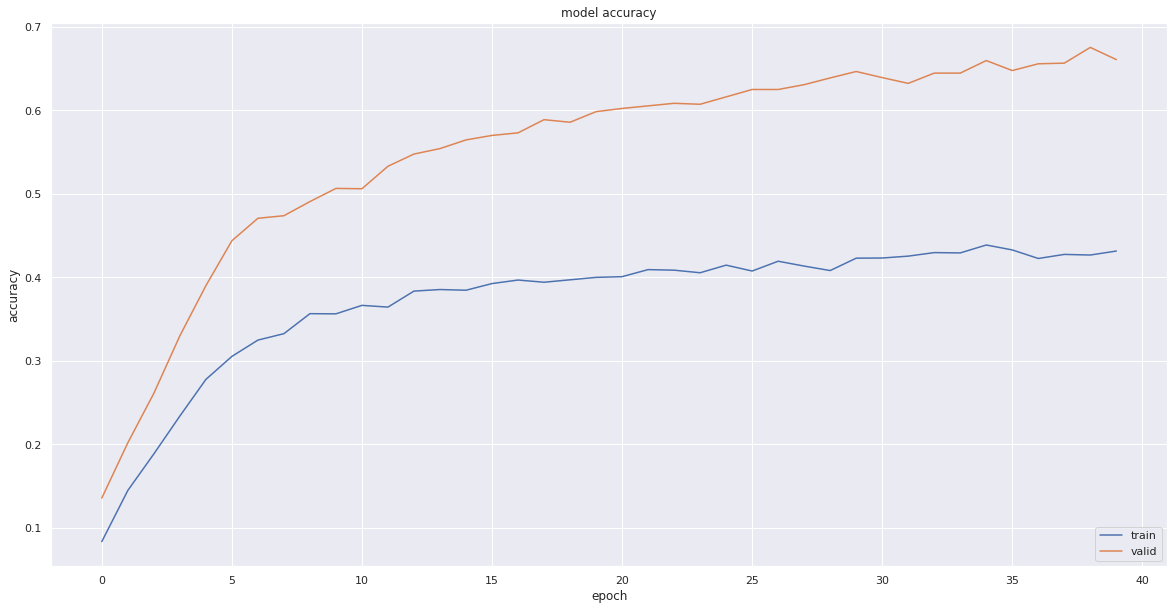

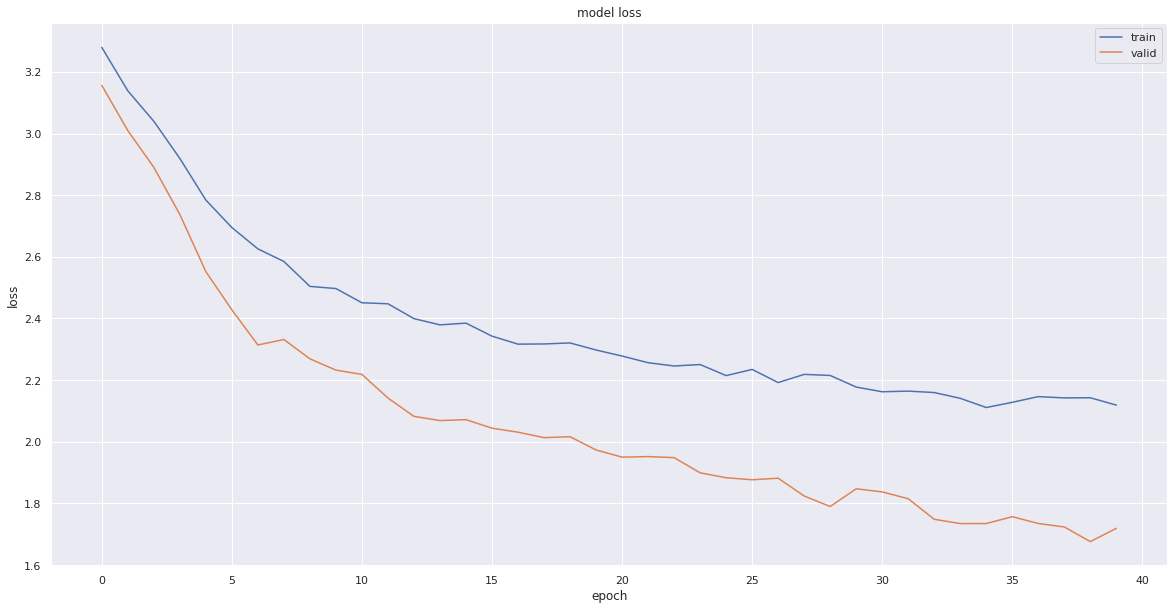

In [18]:
epochs = 40
batch_size = 100

train_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

validation_generator = datagen.flow(
    train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

datagen.fit(train_data)
history = model_1.fit(
    train_generator,
    steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
    validation_data = validation_generator,
    validation_steps = len(train_data) * validation_split // batch_size,
    epochs = epochs, 
    #callbacks = [tensorboard],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [19]:
#%tensorboard --logdir logs

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 1.1360 - accuracy: 0.7979
test loss, test acc: [1.1359851360321045, 0.7979166507720947]
{'loss': 1.1359851360321045, 'accuracy': 0.7979166507720947}


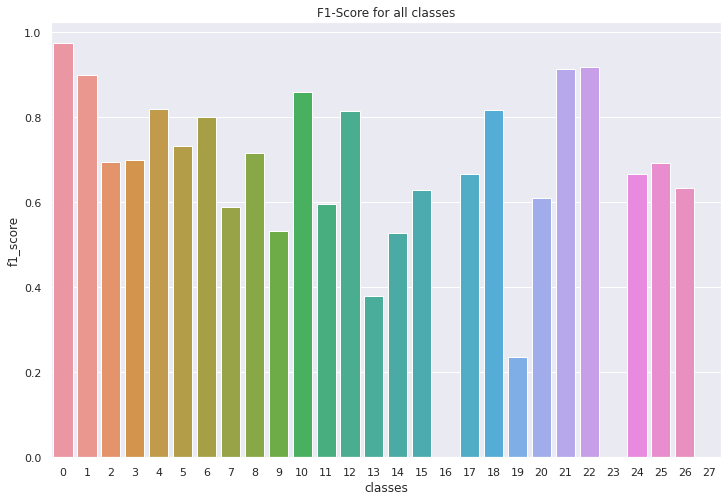

In [22]:
print("Evaluate on test data")
result = model_1.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_1.metrics_names, result)))

# Save model
model_1.save(path_project_dir.joinpath('models','model_1.h5'))

# Create predictions
y_pred = np.around(model_1.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics1 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics1, 
    columns = list(metrics1.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 2 

### Architecture
[CONV2D - MAXPOOL] [CONV2D - MAXPOOL] [DENSE - DROPOUT - DENSE]

In [23]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(32, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

model_2.add(Conv2D(64, (3, 3)))
model_2.add(Activation('relu'))
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_2.add(Flatten())  
model_2.add(Dense(64))
model_2.add(Activation('relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(num_classes))
model_2.add(Activation('softmax'))

model_2.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['accuracy']
)

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        320       
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 32)        9248      
                                                                 
 activation_8 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 4s 35ms/step - loss: 3.3255 - accuracy: 0.0499 - val_loss: 3.3110 - val_accuracy: 0.0604
Epoch 2/150
107/107 [==============================] - 3s 31ms/step - loss: 3.2915 - accuracy: 0.0653 - val_loss: 3.2445 - val_accuracy: 0.0892
Epoch 3/150
107/107 [==============================] - 3s 32ms/step - loss: 3.2022 - accuracy: 0.0875 - val_loss: 3.0996 - val_accuracy: 0.1296
Epoch 4/150
107/107 [==============================] - 3s 32ms/step - loss: 3.0515 - accuracy: 0.1302 - val_loss: 2.9251 - val_accuracy: 0.1642
Epoch 5/150
107/107 [==============================] - 3s 32ms/step - loss: 2.9107 - accuracy: 0.1549 - val_loss: 2.7558 - val_accuracy: 0.2135
Epoch 6/150
107/107 [==============================] - 3s 32ms/step - loss: 2.7583 - accuracy: 0.1981 - val_loss: 2.6278 - val_accuracy: 0.2369
Epoch 7/150
107/107 [==============================] - 3s 32ms/step - loss: 2.6279 - accuracy: 0.2209 - val_loss: 2.4725 - val_accuracy:

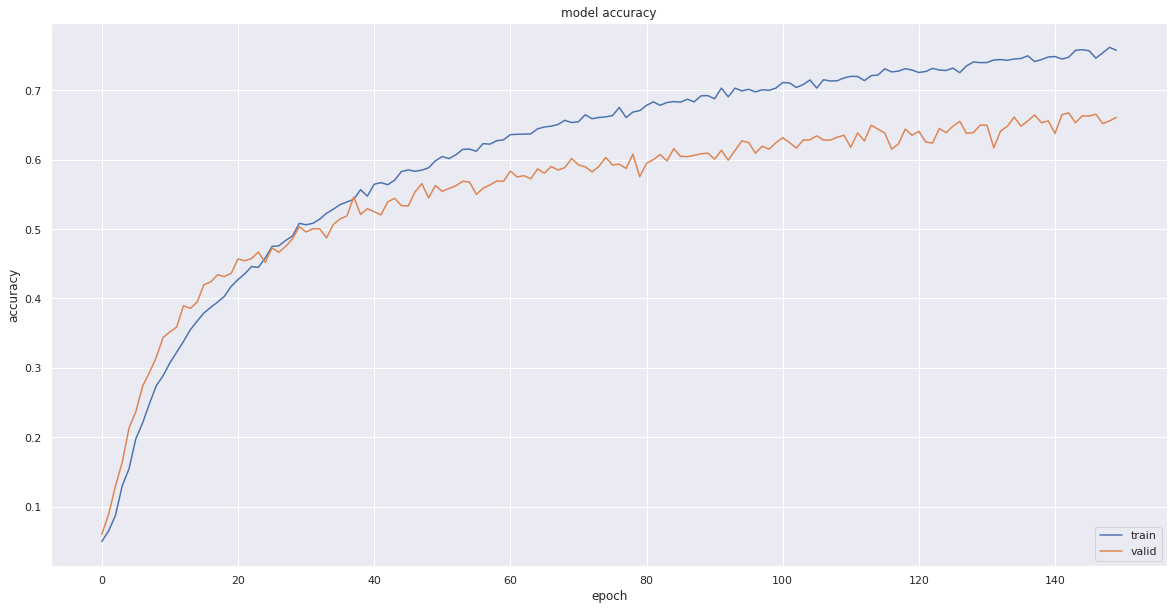

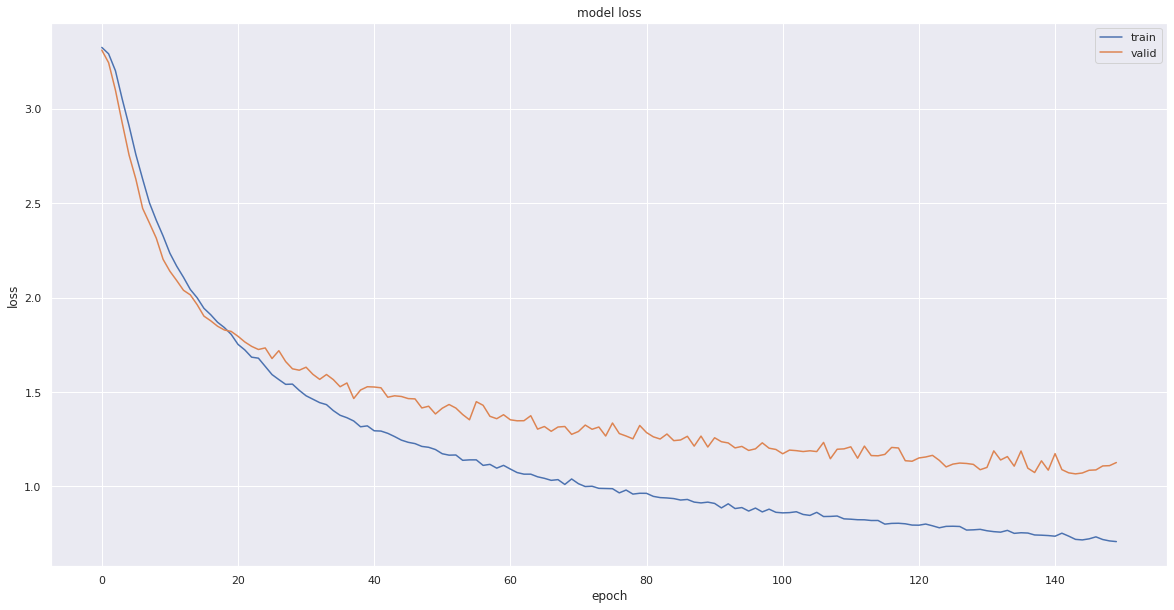

In [24]:
with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_2.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 4ms/step - loss: 0.4298 - accuracy: 0.8622
test loss, test acc: [0.4298064708709717, 0.8622024059295654]
{'loss': 0.4298064708709717, 'accuracy': 0.8622024059295654}


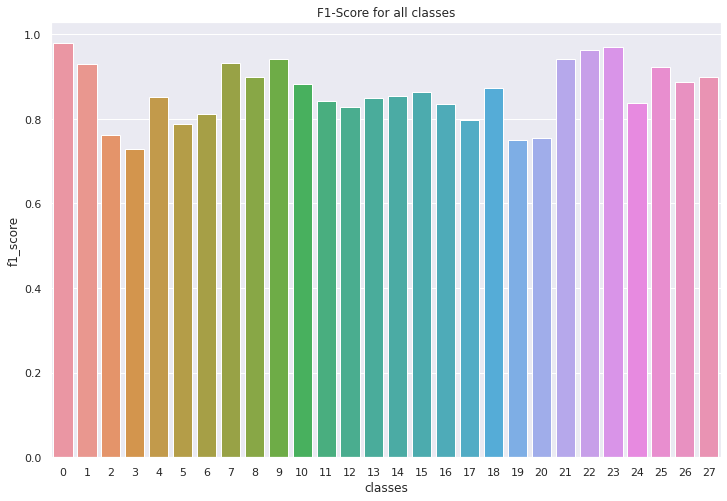

In [25]:
print("Evaluate on test data")
result = model_2.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_2.metrics_names, result)))

# Save model
model_2.save(path_project_dir.joinpath('models','model_2.h5'))

# Create predictions
y_pred = np.around(model_2.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics2 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics2, 
    columns = list(metrics2.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 3 Modifications increasing `learning_rate`. 
The learning rate of our model was not declining fast enough, therefore we have adapted our learning rate, we decrease it by a factor of 10. 

### Architecture

In [27]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(32, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

model_3.add(Conv2D(64, (3, 3)))
model_3.add(Activation('relu'))
model_3.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_3.add(Flatten())  
model_3.add(Dense(64))
model_3.add(Activation('relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(num_classes))
model_3.add(Activation('softmax'))

model_3.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_3.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 32, 32, 32)        320       
                                                                 
 activation_17 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 14, 14, 32)        9248      
                                                                 
 activation_18 (Activation)  (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                  

### Fit

Epoch 1/150
107/107 [==============================] - 4s 33ms/step - loss: 3.0829 - accuracy: 0.1063 - val_loss: 2.6018 - val_accuracy: 0.2558
Epoch 2/150
107/107 [==============================] - 3s 32ms/step - loss: 2.4037 - accuracy: 0.2594 - val_loss: 1.9847 - val_accuracy: 0.3662
Epoch 3/150
107/107 [==============================] - 3s 31ms/step - loss: 1.9117 - accuracy: 0.3691 - val_loss: 1.6989 - val_accuracy: 0.4508
Epoch 4/150
107/107 [==============================] - 3s 32ms/step - loss: 1.6074 - accuracy: 0.4573 - val_loss: 1.5516 - val_accuracy: 0.5012
Epoch 5/150
107/107 [==============================] - 3s 32ms/step - loss: 1.4421 - accuracy: 0.5132 - val_loss: 1.4757 - val_accuracy: 0.5323
Epoch 6/150
107/107 [==============================] - 3s 32ms/step - loss: 1.3289 - accuracy: 0.5417 - val_loss: 1.3904 - val_accuracy: 0.5477
Epoch 7/150
107/107 [==============================] - 3s 32ms/step - loss: 1.2249 - accuracy: 0.5785 - val_loss: 1.3332 - val_accuracy:

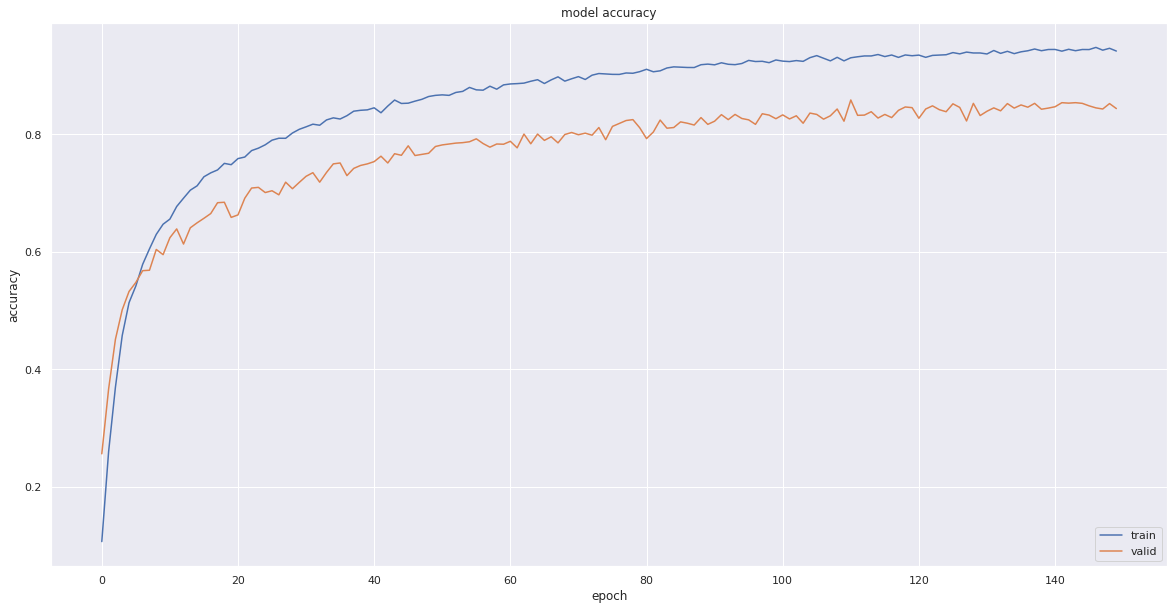

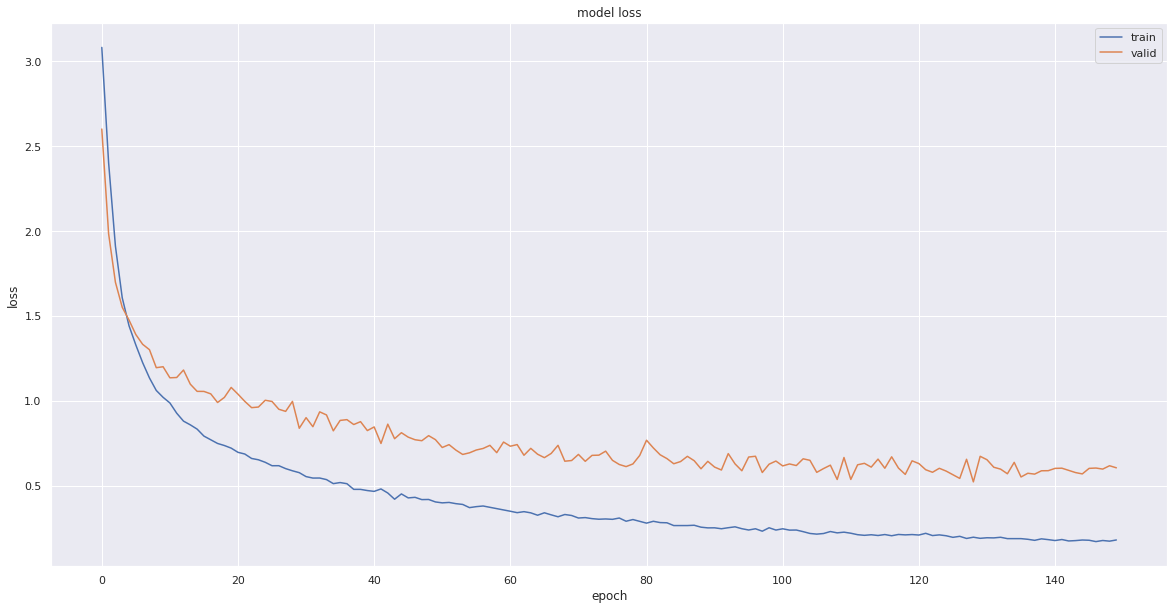

In [30]:
with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_3.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 3ms/step - loss: 0.1910 - accuracy: 0.9580
test loss, test acc: [0.19096197187900543, 0.9580357074737549]
{'loss': 0.19096197187900543, 'accuracy': 0.9580357074737549}


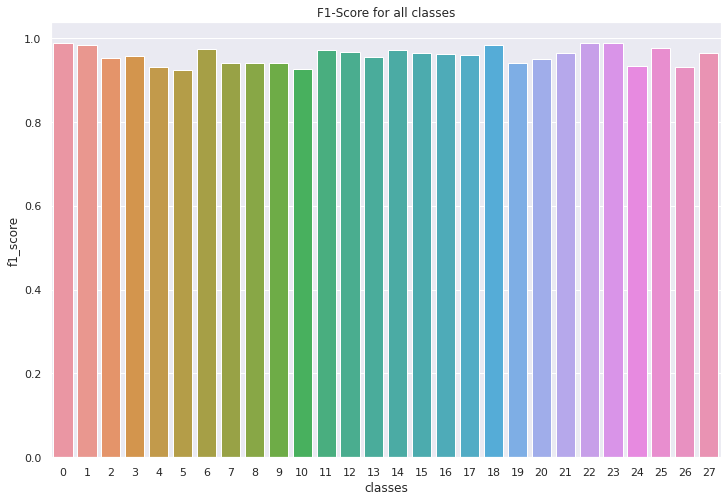

In [31]:
print("Evaluate on test data")
result = model_3.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_3.metrics_names, result)))

# Save model
model_3.save(path_project_dir.joinpath('models','model_3.h5'))

# Create predictions
y_pred = np.around(model_3.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics3 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics3, 
    columns = list(metrics3.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()

## Model 4 Modification of CONV2D

### Architecture

In [15]:
num_classes = train_label.shape[1]
image_size = train_data.shape[1]

model_4 = tf.keras.Sequential()
model_4.add(Conv2D(64, (3, 3), padding='same', input_shape = (image_size, image_size, 1)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

model_4.add(Conv2D(32, (3, 3)))
model_4.add(Activation('relu'))
model_4.add(MaxPooling2D(pool_size=(2, 2)))

# this converts our 3D feature maps to 1D feature vectors
model_4.add(Flatten())  
model_4.add(Dense(64))
model_4.add(Activation('relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(num_classes))
model_4.add(Activation('softmax'))

model_4.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model_4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 activation (Activation)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        18464     
                                                                 
 activation_1 (Activation)   (None, 14, 14, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                    

### Fit

Epoch 1/150
107/107 [==============================] - 14s 48ms/step - loss: 3.2101 - accuracy: 0.0758 - val_loss: 2.8757 - val_accuracy: 0.1696
Epoch 2/150
107/107 [==============================] - 5s 46ms/step - loss: 2.6893 - accuracy: 0.1855 - val_loss: 2.2612 - val_accuracy: 0.3065
Epoch 3/150
107/107 [==============================] - 5s 45ms/step - loss: 2.1739 - accuracy: 0.2943 - val_loss: 1.9493 - val_accuracy: 0.3815
Epoch 4/150
107/107 [==============================] - 5s 45ms/step - loss: 1.8451 - accuracy: 0.3803 - val_loss: 1.6766 - val_accuracy: 0.4381
Epoch 5/150
107/107 [==============================] - 5s 45ms/step - loss: 1.6521 - accuracy: 0.4358 - val_loss: 1.6322 - val_accuracy: 0.4508
Epoch 6/150
107/107 [==============================] - 5s 46ms/step - loss: 1.4840 - accuracy: 0.4868 - val_loss: 1.4997 - val_accuracy: 0.4988
Epoch 7/150
107/107 [==============================] - 5s 45ms/step - loss: 1.3741 - accuracy: 0.5283 - val_loss: 1.4557 - val_accuracy

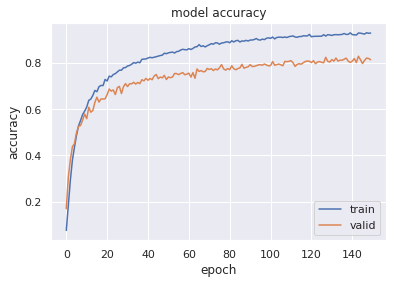

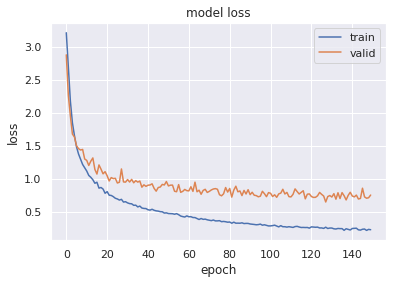

In [17]:
device_name = tf.test.gpu_device_name()

with tf.device('/device:GPU:0'):
  epochs = 150
  batch_size = 100

  train_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'training', shuffle = True, seed = 123)

  validation_generator = datagen.flow(
      train_data,train_label, batch_size = batch_size, subset = 'validation', shuffle = True, seed = 123)

  datagen.fit(train_data)
  history = model_4.fit(
      train_generator,
      steps_per_epoch = len(train_data) * (1 - validation_split) // batch_size,
      validation_data = validation_generator,
      validation_steps = len(train_data) * validation_split // batch_size,
      epochs = epochs, 
      #callbacks = [tensorboard],
  )

  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='lower right')
  plt.show()

  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

### Evaluation

Evaluate on test data
34/34 [==============================] - 0s 5ms/step - loss: 0.2324 - accuracy: 0.9446
test loss, test acc: [0.232401043176651, 0.9446428418159485]
{'loss': 0.232401043176651, 'accuracy': 0.9446428418159485}


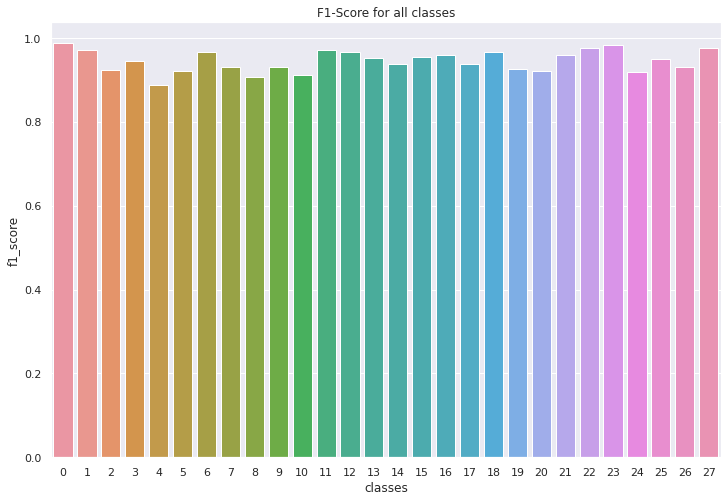

In [18]:
print("Evaluate on test data")
result = model_4.evaluate(test_data, test_label, batch_size = batch_size)
print("test loss, test acc:", result)
print(dict(zip(model_4.metrics_names, result)))

# Save model
model_4.save(path_project_dir.joinpath('models','model_4.h5'))

# Create predictions
y_pred = np.around(model_4.predict(test_data))
# Round test_data
#y_test = np.argmax(test_data, axis=1)

# Create report
metrics4 = classification_report(
      test_label,
      y_pred, 
      zero_division = True,
      #labels = test_label,
      output_dict = True
)

# Convert metrics to a df
df_metrics = (pd.DataFrame(
    metrics4, 
    columns = list(metrics4.keys())
    )
    .T
    .drop(['samples avg','weighted avg','macro avg','micro avg'])
    .reset_index()
    .rename(columns={'index':'classes','f1-score':'f1_score'})
    .drop(columns=['support'])
    
)

# Barplot of f1 score
plt.figure(figsize=(12, 8))
sns.barplot(
    x = df_metrics.classes,
    y = df_metrics.f1_score,
    data = df_metrics,
    #hue="model"
)

plt.title('F1-Score for all classes')
plt.show()